Лабораторная работа №2

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pylab as plt
from scipy import optimize as opt
from scipy.io import loadmat
from matplotlib import pyplot as ppl

# 1. Загрузите данные ex2data1.txt из текстового файла.
data_first = pd.read_csv("ex2data1.txt", names=("FirstMark", "SecondMark", "Passed"))

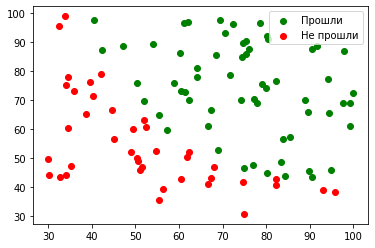

In [3]:
# 2. Постройте график, где по осям откладываются оценки по предметам, а точки обозначаются двумя разными маркерами в зависимости от того, поступил ли данный студент в университет или нет.
passed = data_first[data_first.Passed == 1]
not_passed = data_first[data_first.Passed == 0]

plt.scatter(passed.FirstMark, passed.SecondMark, c="green")
plt.scatter(not_passed.FirstMark, not_passed.SecondMark, c="red")
plt.legend(["Прошли", "Не прошли"])
plt.show()

data_first.insert(0, "X0", 1)

In [3]:
# 3. Реализуйте функции потерь J(θ) и градиентного спуска для логистической регрессии с использованием векторизации.


def hypothesis(*args, x):
    rate=(x @ np.array([args]).T)
    return 1/(1 + np.exp(-rate))

def loss_function(*args, data):
    size = len(data)
    # Т.к. hypothesis -> 0, мы не сможем взять логарифм от 0, вводим коэффициент.
    epsilon = 1e-10
    y = data.iloc[:,-1].to_numpy()
    x = data.iloc[:, list(range(0, data.columns.size -1))].to_numpy()
    h = hypothesis(*args, x=x)
    return -((y @ np.log(h + epsilon) + (1-y) @ np.log(1-h + epsilon)).sum()) / size

def gradient_descent(alfa, *args, data, iterations = 10**6):
    thetas = np.array(args)
    size = len(data)
    y = data.iloc[:,-1].to_numpy().reshape(1, size).T
    x = data.iloc[:, list(range(0, data.columns.size -1))].to_numpy()
    while iterations > 0:
        thetas_for_hypothesis = thetas.tolist()
        thetas = thetas - alfa * np.sum((hypothesis(*thetas_for_hypothesis, x=x) - y)*x, axis=0)/size
        iterations -= 1
    return thetas.tolist()

thetas_result = gradient_descent(0.01, 0, 0, 0, data=data_first)
print("Результат градиентного спуска: ", thetas_result)
print("Результат функции потерь: ", loss_function(*thetas_result, data=data_first))

Результат градиентного спуска:  [-59.19582083466895, 0.4971076868182841, 0.48980158789450556]
Результат функции потерь:  0.32965405458561325


In [4]:
# 4. Реализуйте другие методы (как минимум 2) оптимизации для реализованной функции стоимости

def loss_function_with_default_data(args):
    return loss_function(*args.tolist(), data=data_first)

print("Результат Нелдер-Мид: ")
thetas_result_other = opt.minimize(loss_function_with_default_data, np.array([[0, 0, 0]]), method="nelder-mead")
print(thetas_result_other)
print("Результат BFGS: " )
thetas_result_other = opt.fmin_bfgs(loss_function_with_default_data, np.array([[0, 0, 0]])).tolist()
print(thetas_result_other)


Результат Нелдер-Мид: 
 final_simplex: (array([[-25.16130062,   0.20623142,   0.20147143],
       [-25.16135807,   0.20623176,   0.20147199],
       [-25.1613519 ,   0.20623203,   0.20147171],
       [-25.16137971,   0.20623202,   0.20147188]]), array([0.2034977, 0.2034977, 0.2034977, 0.2034977]))
           fun: 0.20349770144622611
       message: 'Optimization terminated successfully.'
          nfev: 287
           nit: 157
        status: 0
       success: True
             x: array([-25.16130062,   0.20623142,   0.20147143])
Результат BFGS: 
Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 20
         Function evaluations: 108
         Gradient evaluations: 27
[-25.161235144141695, 0.20623094883117477, 0.20147077842143987]


In [5]:
# 5. Реализуйте функцию предсказания вероятности поступления студента в зависимости от значений оценок по экзаменам.
def prediction(x):
    return int(np.round(hypothesis(*thetas_result, x=np.array([[1] + x]))))

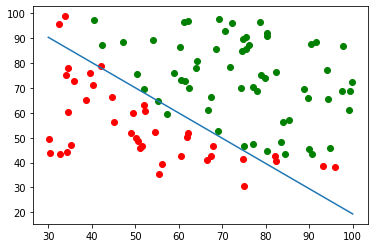

In [6]:
# 6. Постройте разделяющую прямую, полученную в результате обучения модели.
def graph_builder(first_x, thetas=thetas_result):
    return -(thetas[0] + thetas[1] * first_x)/thetas[2]

first_x = np.array([30, 100])
second_x = graph_builder(first_x)

plt.scatter(passed.FirstMark, passed.SecondMark, c="green")
plt.scatter(not_passed.FirstMark, not_passed.SecondMark, c="red")
plt.plot(first_x, second_x)
plt.show()

In [4]:
# 7. Загрузите данные ex2data2.txt

data_second = pd.read_csv("ex2data2.txt", names=("FirstMark", "SecondMark", "Passed"))

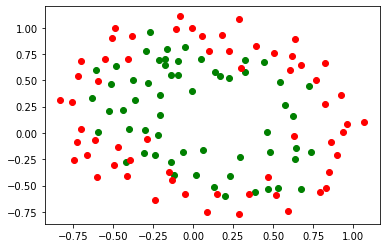

In [8]:
# 8. Постройте график, где по осям откладываются результаты тестов

passed = data_second[data_second.Passed == 1]
not_passed = data_second[data_second.Passed == 0]

plt.scatter(passed.FirstMark, passed.SecondMark, c="green")
plt.scatter(not_passed.FirstMark, not_passed.SecondMark, c="red")
plt.show()

data_second.insert(0, "X0", 1)

In [5]:
# 9. Постройте все возможные комбинации признаков

column = 3
for first in range(7):
    for second in range(7):
        if first + second > 6 or (first == 1 and second == 0) or (first == 0 and second == 1) or (first == 0 and second == 0):
            continue
        data_second.insert(column, f"X1^{first}*X2^{second}", (data_second.iloc[:, 1]**first)*data_second.iloc[:, 2]**second)
        column += 1


In [10]:
# 10. Реализуйте L2-регуляризацию для логистической регрессии и обучите ее на расширенном наборе признаков методом градиентного спуска.
def loss_function_with_lambda(l, *args, data):
    size = len(data)
    thetas = np.array(args)
    thetas[0] = 0
    return loss_function(*args, data = data) + 0.5 * l * np.sum(thetas**2)/ size

def gradient_descent_with_lambda(alfa, l, *args, data, iterations = 10**4):
    thetas = np.array(args)
    size = len(data)
    y = data.iloc[:,-1].to_numpy().reshape(1, size).T
    x = data.iloc[:, list(range(0, data.columns.size -1))].to_numpy()
    while iterations > 0:
        thetas_for_l = thetas.copy()
        thetas_for_l[0] = 0
        thetas_for_hypothesis = thetas.tolist()
        thetas = thetas - alfa * (np.sum((hypothesis(*thetas_for_hypothesis, x=x) - y)*x, axis=0)/size + l * thetas_for_l / size)
        iterations -= 1
    return thetas.tolist()

thetas_start = np.zeros((1, 28)).tolist()[0]
thetas_result = np.array(gradient_descent_with_lambda(0.1, 0.01, *thetas_start, data=data_second))
print("Результат градиентного спуска: ", thetas_result)

Результат градиентного спуска:  [ 3.17551048  2.23818281  3.470607   -4.83823367 -0.32559973 -3.28057005
 -0.25827212 -1.64983848 -3.9723087  -0.92383367 -1.48577934 -1.43748991
 -1.09294994 -4.91363    -1.45709096 -2.11852639 -1.24447411 -1.26244713
  0.97908509  0.27418054  0.40337502  0.28350543 -3.98913309 -0.6840766
 -0.94011183 -0.59473181  0.36088213 -3.15549257]


In [11]:
# 11. Реализуйте другие методы оптимизации.

def loss_function_regularized_with_default_data(*args):
    return loss_function_with_lambda(args[1][0], *args[0].tolist(), data=data_second)

print("Результат Нелдер-Мид: ")
thetas_result_other = opt.minimize(loss_function_regularized_with_default_data, np.zeros((1, 28)), args=[0.01], method="nelder-mead").x
print(thetas_result_other)
print("Результат BFGS: " )
thetas_result_other = opt.minimize(loss_function_regularized_with_default_data, np.zeros((1, 28)), args=[0.01], method="bfgs").x
print(thetas_result_other)

Результат Нелдер-Мид: 
[ 2.71239947 -0.29794976  2.74824152 -1.92585718  1.22488936 -1.29203532
 -4.00083576 -2.70029345 -1.5194855   1.9265074  -7.99079586  1.65506756
  6.58882241 -7.78931307 -1.97524168 -1.21793609  3.40460475  2.49712467
  3.32533794  1.12280617 -2.34991746  4.0507921  -3.96444155 -3.23256864
  0.76514469  0.12881867  2.57032568  3.80299302]
Результат BFGS: 
[ 3.79123189  2.05154728  4.65815163 -6.07125553 -2.58862229 -6.24723085
  2.87355514  0.2828599  -6.68663374  2.43246895 -1.99564172 -4.34547978
 -3.6083801  -5.58624482 -0.13063803 -3.71079301 -3.61488335 -4.44682189
  2.08911116  2.99731643  5.06876088  3.1731519  -3.75647572 -0.88328495
 -0.82639971 -1.74966979  0.48120354 -5.35357209]


In [12]:
# 12. Реализуйте функцию предсказания вероятности прохождения контроля изделием в зависимости от результатов тестов.

def prediction(x):
    for first in range(7):
        for second in range(7):
            if first + second > 6 or (first == 1 and second == 0) or (first == 0 and second == 1) or (first == 0 and second == 0):
                continue
            append_x = x[0]**first*x[1]**second
            x = x + [append_x]
    return int(np.round(hypothesis(*thetas_result, x=np.array([x]))))

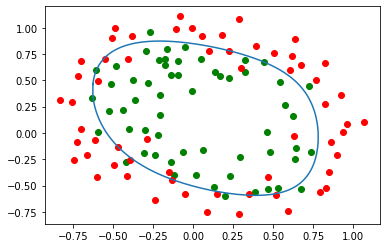

In [13]:
# 13. Постройте разделяющую кривую, полученную в результате обучения модели.

def graph_builder(x0, x1):
    def get_result(second_x, first_x):
        result = thetas_result[0] + thetas_result[1]*first_x[0] + thetas_result[2]*second_x
        i = 3
        for first in range(7):
            for second in range(7):
                if first + second > 6 or (first == 1 and second == 0) or (first == 0 and second == 1) or (first == 0 and second == 0):
                    continue
                result += thetas_result[i] * first_x[0]**first * second_x**second
                i += 1
        return result
    sol, info, ier, msg = opt.fsolve(get_result, np.array([x0]), args=[x1], full_output=True)
    if ier == 1:
        return sol[0]
    else:
        return None

def graph_builder_first(first_x):
    return graph_builder(1, first_x)
def graph_builder_second(first_x):
    return graph_builder(-1, first_x)

def draw_result():
    first_x = np.arange(-1, 1, 0.003)
    second_x = np.append(np.vectorize(graph_builder_first)(first_x), np.vectorize(graph_builder_second)(first_x[::-1])).flatten()
    plot = np.array(list(zip(np.append(first_x, first_x[::-1]), second_x)))
    plot = plot[plot[:,1] != None, :]

    passed = data_second[data_second.Passed == 1]
    not_passed = data_second[data_second.Passed == 0]

    plt.scatter(passed.FirstMark, passed.SecondMark, c="green")
    plt.scatter(not_passed.FirstMark, not_passed.SecondMark, c="red")
    plt.plot(np.append(plot[:, 0], plot[0, 0]).flatten(), np.append(plot[:,1], plot[0,1]).flatten())
    plt.show()

draw_result()


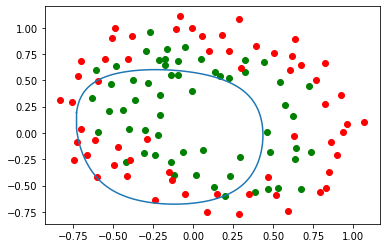

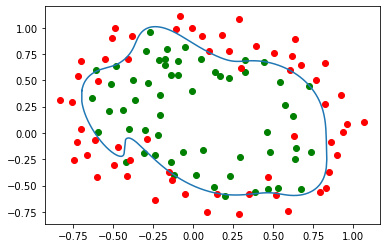

In [14]:
# 14. Попробуйте различные значения параметра регуляризации λ.
thetas_result = opt.minimize(loss_function_regularized_with_default_data, np.zeros((1, 28)), args=[100], method="bfgs").x
draw_result()

thetas_result = opt.minimize(loss_function_regularized_with_default_data, np.zeros((1, 28)), args=[1e-10], method="bfgs").x
draw_result()

In [6]:
# 15. Загрузите данные ex2data3.mat из файла.

mat = loadmat('ex2data3.mat')
data_third = pd.DataFrame(np.hstack((mat['X'], mat['y'])))


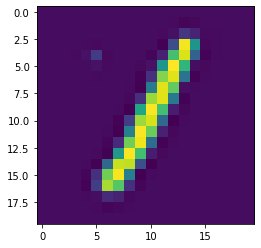

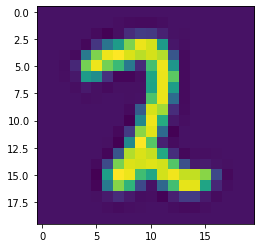

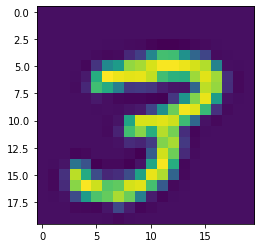

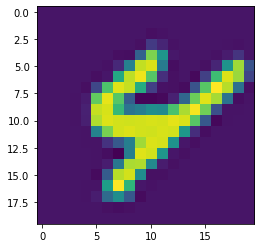

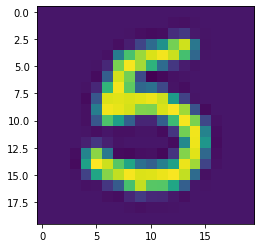

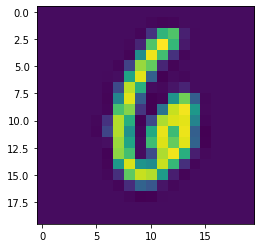

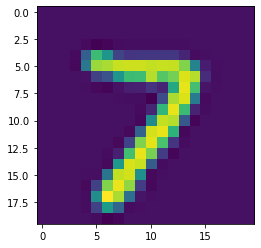

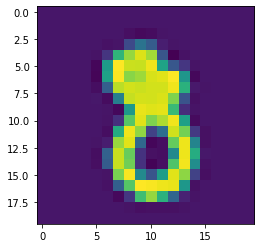

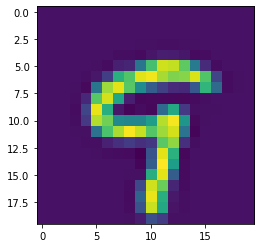

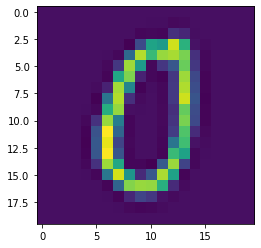

In [16]:
# 16. Визуализируйте несколько случайных изображений из набора данных.
for number in range(1,11):
    frame: pd.DataFrame  = data_third[data_third.iloc[:,-1] == number]
    pixels: np.ndarray = frame.iloc[np.random.randint(0, len(frame))].iloc[:-1].to_numpy().reshape(20, 20).T
    ppl.imshow(pixels)
    plt.show()

data_third.insert(0, "First", 1)

In [17]:
# 17. Реализуйте бинарный классификатор с помощью логистической регрессии с использованием векторизации

thetas_result = {}
for number in range(1, 11):
    data_third_binary: pd.DataFrame = data_third.copy()
    data_third_binary.loc[data_third_binary.iloc[:, -1] != number, data_third_binary.columns[-1]] = 0
    data_third_binary.loc[data_third_binary.iloc[:, -1] == number, data_third_binary.columns[-1]] = 1
    thetas_start = np.zeros((1, data_third_binary.columns.size - 1)).tolist()[0]
    res = gradient_descent(0.9, *thetas_start, data=data_third_binary, iterations=50**2)
    thetas_result[number] = res

In [18]:
# 18. Добавьте L2-регуляризацию к модели.
# 19. Реализуйте многоклассовую классификацию по методу “один против всех”.

for number in range(1, 11):
    data_third_binary: pd.DataFrame = data_third.copy()
    data_third_binary.loc[data_third_binary.iloc[:, -1] != number, data_third_binary.columns[-1]] = 0
    data_third_binary.loc[data_third_binary.iloc[:, -1] == number, data_third_binary.columns[-1]] = 1
    thetas_start = np.zeros((1, data_third_binary.columns.size - 1)).tolist()[0]
    res = gradient_descent_with_lambda(0.9, 0.1, *thetas_start, data=data_third_binary, iterations=15**3)
    thetas_result[number] = res

In [19]:
# 20. Реализуйте функцию предсказания класса по изображению с использованием обученных классификаторов.

def prediction(x):
    results = {}
    for key, value in thetas_result.items():
        results[key] = hypothesis(*value, x=x)
    high_value = max(results.values())
    for key, value in results.items():
        if value == high_value:
            return key

In [20]:
# 21. Процент правильных классификаций на обучающей выборке должен составлять около 95%.

result = np.apply_along_axis(prediction, 1, data_third.iloc[:, 0:-1].to_numpy())
correct_results = data_third.iloc[:, -1].to_numpy()

success_number = 0
for i in range(len(result)):
    if result[i] == correct_results[i] :
        success_number += 1

print("Процент правильных классификаций: ", 100 * success_number/len(result))

Процент правильных классификаций:  94.22
